# Bayesian Neural Network (VI) for regression

### Zhenwen Dai (2018-8-21)

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

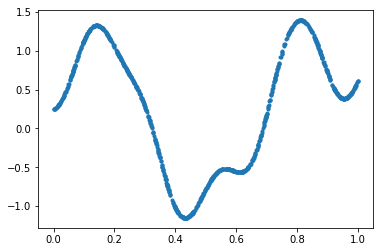

In [2]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(0)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(1000,1)
y = np.random.multivariate_normal(mean=np.zeros((1000,)), cov=k.K(x), size=(1,)).T
plot(x[:,0], y[:,0], '.')

## Model definition

In [3]:
D = 50
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(D, activation="tanh"))
    net.add(nn.Dense(1, flatten=True))
net.initialize(mx.init.Xavier(magnitude=3))
_=net(mx.nd.array(x))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [5]:
m = mf.Model()
m.N = mf.Variable()
m.f = mf.functions.MXFusionGluonFunction(net, num_outputs=1,broadcastable=False)
m.x = mf.Variable(shape=(m.N,1))
m.v = mf.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
#m.prior_variance = mf.core.Variable(shape=(1,), transformation=PositiveTransformation())
m.r = m.f(m.x)
for v in m.r.factor.parameters.values():
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([1.])))
m.y = mf.distributions.Normal.define_variable(mean=m.r, variance=m.v, shape=(m.N,1))
print(m)

Variable(746e9) ~ Normal(mean=Variable(15143), variance=Variable(e7a3a))
Variable(adf9f) ~ Normal(mean=Variable(dfd4f), variance=Variable(65d0f))
Variable(f6028) ~ Normal(mean=Variable(7d834), variance=Variable(57cde))
Variable(0f787) ~ Normal(mean=Variable(5a470), variance=Variable(9ed1d))
Variable(707d8) ~ Normal(mean=Variable(0fb74), variance=Variable(b9249))
Variable(5868e) ~ Normal(mean=Variable(5f168), variance=Variable(9986c))
r = GluonFunctionEvaluation(nn_input_0=x, nn_dense0_weight=Variable(5868e), nn_dense0_bias=Variable(707d8), nn_dense1_weight=Variable(0f787), nn_dense1_bias=Variable(f6028), nn_dense2_weight=Variable(adf9f), nn_dense2_bias=Variable(746e9))
y ~ Normal(mean=r, variance=v)


## Inference with Meanfield

In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.parameters.items():
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-6
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [10]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 201 loss: 15813.8652343755
Iteration 401 loss: 11816.2539062575
Iteration 601 loss: 8878.53613281255
Iteration 801 loss: 6882.62304687555
Iteration 1001 loss: 4587.88476562575
Iteration 1201 loss: 3141.454101562575
Iteration 1401 loss: 2384.041748046875
Iteration 1601 loss: 1506.3939208984375
Iteration 1801 loss: 1371.0895996093755
Iteration 2000 loss: 1076.2845458984375

## Use prediction to visualize the resulting BNN

In [11]:
xt = np.linspace(0,1,100)[:,None]

In [12]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [13]:
yt = res[m.r].asnumpy()

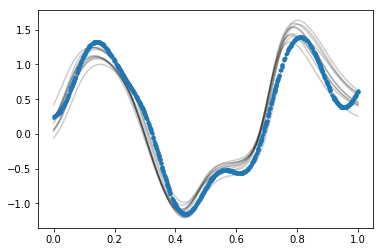

In [14]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)

for i in range(yt.shape[0]):
    plot(xt[:,0],yt[i,:,0],'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')